In [3]:
import tweepy  # Twitter API helper package
from tweepy import OAuthHandler
import pprint # to print human readable dictionary
import pandas as pd # for visualizations
import json # for json methods

import pymongo # for pymongo functions
import psycopg2 # for POSTGRESQL
from psycopg2.pool import ThreadedConnectionPool
from contextlib import contextmanager

import time # for debug
from datetime import datetime # to print the date & time in the output log whenever this script is run OR for time related checks
from tfidf_vectorizer import TwitterAccountSimilarityFinder
import numpy as np
import re # regex
from sklearn import linear_model
%matplotlib inline

In [4]:
# from textblob import TextBlob # for NLP
# need to resolve unknown locale: UTF-8 error

In [5]:
def getLocalAudience(topic_id,location,signal_strength):
    '''
        Returns the local audience for the given topic.
    '''
    start=time.time()
    regx = location_regex.getLocationRegex(location)
    loc_filtered_audience_ids = []
    try:
        loc_filtered_audience_ids = audienceDB[str(topic_id)].distinct('id', {'location': {'$regex':regx}, '$where':'this.influencers.length > ' + str(signal_strength)})
    except:
        print("Slow audience retrieval")
        for aud in audienceDB[str(topic_id)].find({'location': {'$regex':regx}, '$where':'this.influencers.length > ' + str(signal_strength)},{'id':1,'_id':0}):
            loc_filtered_audience_ids.append(aud['id'])

    audience=list(audienceDB['all_audience'].find({'id':{'$in':loc_filtered_audience_ids}},{'id':1, 'screen_name':1, 'location':1, 'description':1, '_id':0}))
    print("Found local audience in " + str(time.time()-start) + " seconds.")
    return audience

In [6]:
def addRatingInformation(audience_dict,topic_id):
    '''
        Adds the rating information to those profiles that have been rated.
    '''
    start = time.time()
    with PostGRESQL.Instance().get_cursor() as cur:
        sql = (
        "SELECT user_id, audience_id,rating "
        "FROM user_audience_rating "
        "WHERE topic_id=" + str(topic_id)
        )
        cur.execute(sql)
        for user_id, audience_id, rating in cur.fetchall():
            if rating == 0: # pass zero ratings
                continue
            if audience_id in audience_dict.keys():
                if 'rating' in audience_dict[audience_id]:
                    audience_dict[audience_id]['rate_count']+=1
                    audience_dict[audience_id]['rating_sum']+=rating
                else:
                    audience_dict[audience_id]['rating_sum']=rating
                    audience_dict[audience_id]['rate_count']=1
    print("Got rating information in " + str(time.time()-start) + " seconds.")

In [7]:
def getInfluencers(audience_dict, topic_id):
    '''
        adds influencers to audience_dict
    '''
    for aud_id, aud in audience_dict.items():
        print("Fetching influencers of: " + aud['screen_name'])
        influencers = [str(infid) for infid in audienceDB[str(topic_id)].find_one({'id':aud_id},{'influencers':1})['influencers']]
        audience_dict[aud_id]['influencers']= " ".join(influencers)

In [8]:
def getTweetsAndHashtags(audience_dict,K, include_retweets):
    '''
        adds tweets(including retweets) and hashtags(in tweets) to audience_dict
    '''
    for aud_id, aud in audience_dict.items():
        print("Fetching tweets of: " + aud['screen_name'])
        tweets =[]
        hashtags=[]
        try: # GET LAST K TWEETS FOR EACH AUDIENCE MEMBER
            for tweet in api.user_timeline(id = aud_id, count = K, include_rts = include_retweets):
                tweet = tweet._json
                for token in tweet['text'].split(" "):
                    if (re.match('^[\w-]+$', token) is not None):
                        tweets.append(token)
                hashtags.extend([e['text'] for e in tweet['entities']['hashtags']])
            audience_dict[aud_id]['tweets']=" ".join(tweets)
            audience_dict[aud_id]['hashtags']= " ".join(hashtags)
        except tweepy.TweepError as twperr:
            print(twperr) # in case of errors due to protected accounts
            audience_dict[aud_id]['tweets']=""
            audience_dict[aud_id]['hashtags']=""
            pass

In [9]:
def calculateMSE(results):
    MSE=0
    for e in results:
        MSE+= (e['predicted_rating']-e['ground_truth_rating'])**2
    return 1.0*MSE/len(results)

In [10]:
TOPIC_ID=31 # topic = arduino
LOCATION = 'italy'
SIGNAL_STRENGTH = 1 # this value indicates the min number of influencers the picked audience members follow within the topic
LIMIT = 30 # number of audience members to consider for sampling
TESTING_SET_SIZE=5
HOW_MANY_TWEETS = 100 # amount of most recent tweets (including retweets) to be retrieved to consider in our recommendation engine
INCLUDE_RETWEETS = True

In [11]:
rated_audience_dict = json.load(open('rated_audience.txt'))
unrated_audience_dict = json.load(open('unrated_audience.txt'))

pprint.pprint(rated_audience_dict)

{'1028535421': {'avg_rating': 0,
                'description': 'Student. I love watching TV & Movies and '
                               'listening to the music.',
                'ground_truth_rating': 0.5,
                'hashtags': 'NashvilleCMT NashvilleCMT Reputation TaylorSwift '
                            'reputation UNAPOLOGETICALLY ReadyForItMusicVideo '
                            'ReadyForItMusicVideo WAVES ReadyForIt LWYMMDvideo '
                            'LookWhatYouMadeMeDo LWYMMDvideo '
                            'LookWhatYouMadeMeDo LookWhatYouMadeMeDo '
                            'TS6ISCOMIMG LEGENDS KelseaBallerini Legends '
                            'MozartInTheJungle MozartInTheJungle WorldMusicDay '
                            'roaming KelseaBallerini Legends KelseaBallerini '
                            'Legends SoGood ZaraLarsson EUDefence '
                            'OneLoveManchester OneLoveManchester ActOnClimate '
                            '2gi

In [12]:
screen_names = [aud['screen_name'] for aud in rated_audience_dict.values()]
ratings = np.array([aud['avg_rating'] for aud in rated_audience_dict.values()])
ground_truth_ratings = np.array([aud['ground_truth_rating'] for aud in rated_audience_dict.values()])
ratings=(2*ratings)
ground_truth_ratings=(2*ground_truth_ratings)
influencers_corpus = [aud['influencers'] for aud in rated_audience_dict.values()]
tweets_corpus = [aud['tweets'] for aud in rated_audience_dict.values()]
hashtags_corpus = [aud['hashtags'] for aud in rated_audience_dict.values()]
description_corpus = [aud['description'] for aud in rated_audience_dict.values()]

In [13]:
# FIND THE COSINE SIMILARITIES
# THESE WILL THEN BE USED AS FEATURES IN REGRESSION
TASF_influencer= TwitterAccountSimilarityFinder(influencers_corpus,ratings)
TASF_tweets= TwitterAccountSimilarityFinder(tweets_corpus,ratings)
TASF_description= TwitterAccountSimilarityFinder(description_corpus,ratings)
TASF_hashtags = TwitterAccountSimilarityFinder(hashtags_corpus,ratings)

influencerSimilarities = TASF_influencer.cos_sim()
tweetSimilarities = TASF_tweets.cos_sim()
descriptionSimilarities = TASF_description.cos_sim()
hashtagSimilarities = TASF_hashtags.cos_sim()

profile_count = min(LIMIT,len(rated_audience_dict))
avgTweetSim = np.mean([e for e in tweetSimilarities if e!=0]) # if we cannot fetch tweets of a profile, we assign his tweets an average similarity score
avgDescriptionSim = np.mean([e for e in descriptionSimilarities if e!=0]) # if the description of a profile is empty, we assign his descripion an average similarity score
avgHashtagSim = np.mean([e for e in hashtagSimilarities if e!=0]) # if we cannot fetch tweets of a profile, we assign his hashtags an average similarity score

In [14]:
profiles =[]
for i in range(profile_count):
    if tweetSimilarities[i]==0: tweetSimilarities[i]= avgTweetSim
    if descriptionSimilarities[i]==0: descriptionSimilarities[i]= avgDescriptionSim
    if hashtagSimilarities[i]==0: hashtagSimilarities[i] = avgHashtagSim
    profile = {
    'screen_name':screen_names[i],
    'rating':ratings[i],
    'ground_truth':ground_truth_ratings[i],
    'infSim': influencerSimilarities[i].item(0),
    'tweetSim': tweetSimilarities[i].item(0),
    'descSim': descriptionSimilarities[i].item(0),
    'hashtagSim': hashtagSimilarities[i].item(0),
    'score': 0
    }
    count=0
    for key in profile.keys():
        if 'Sim' in key: 
            profile['score']+=profile[key]
            count+=1
    profile['score']/=count*1.0
    profiles.append(profile)

profiles=pd.DataFrame(profiles)
profiles[['screen_name','rating','ground_truth','score','infSim','tweetSim','descSim','hashtagSim']].sort_values(by='score',ascending=False).round(2)


,screen_name,rating,ground_truth,score,infSim,tweetSim,descSim,hashtagSim
22,NicolaLamacchia,10.0,10.0,0.52,0.80,0.62,0.33,0.33
5,fibasile,10.0,10.0,0.46,0.50,0.65,0.33,0.35
13,olivier_morandi,9.0,9.0,0.45,0.50,0.65,0.33,0.32
17,zetaerre65,7.0,7.0,0.40,0.80,0.41,0.22,0.18
14,designcomposer,5.0,5.0,0.40,0.80,0.46,0.16,0.19
6,zilviastardust,6.0,6.0,0.39,0.48,0.61,0.25,0.21
20,codecreativity,8.0,8.0,0.38,0.66,0.30,0.26,0.29
2,mdigenov,4.0,4.0,0.37,0.80,0.30,0.21,0.15
4,bittenapple,10.0,10.0,0.37,0.44,0.35,0.34,0.33
3,albertosarullo,5.0,5.0,0.36,0.39,0.61,0.24,0.18


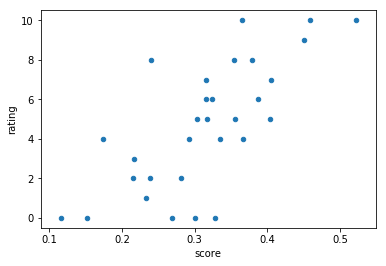

In [15]:
profiles.plot.scatter('score','rating') # score is the average of the similarities

In [16]:
# Combine the similarities and use them as features to feed to a logistic regressor.
# uncomment to add the similarity into regression

featureVectors = np.column_stack((influencerSimilarities,tweetSimilarities))
#featureVectors = np.column_stack((featureVectors, descriptionSimilarities))
#featureVectors = np.column_stack((featureVectors, hashtagSimilarities))

X = featureVectors[:LIMIT-TESTING_SET_SIZE] # we are only using the data points in the training set
Y = ratings[:LIMIT-TESTING_SET_SIZE]
# squash ratings to 0-1. 1 if rating >=2.5, 0 otherwise
#Y = [((round(rating/5))) for rating in ratings[:LIMIT-TESTING_SET_SIZE]]
# LOGISTIC REGRESSION
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [17]:
results = []
for i in range(profile_count):
    rating_given = ratings[i]/2.0
    set = "training"
    if rating_given ==0:
        set="testing"
    predicted_rating = logreg.predict(featureVectors[i])[0]
    results.append({'predicted_rating':predicted_rating, 'set':set, 'ground_truth_rating':ground_truth_ratings[i], 'screen_name':screen_names[i] })

In [18]:
results=pd.DataFrame(results)
results["squared_error"]=(results["ground_truth_rating"]-results["predicted_rating"])**2
display(results[['set','screen_name','ground_truth_rating','predicted_rating',"squared_error"]].sort_values(by='set',ascending=False).round(2))

,set,screen_name,ground_truth_rating,predicted_rating,squared_error
0,training,funkysurfer,6.0,5.0,1.0
13,training,olivier_morandi,9.0,9.0,0.0
24,training,efotografica,4.0,5.0,1.0
23,training,IeengSolution,5.0,5.0,0.0
22,training,NicolaLamacchia,10.0,10.0,0.0
21,training,oscar970,2.0,5.0,9.0
20,training,codecreativity,8.0,4.0,16.0
19,training,danpir,6.0,4.0,4.0
18,training,cabaio,5.0,5.0,0.0
17,training,zetaerre65,7.0,4.0,9.0


In [19]:
# EVALUATION
evaluation = pd.DataFrame()
evaluation['mean_squared_error']=results.groupby(by='set')['squared_error'].mean()
display(evaluation)

,mean_squared_error
set,
testing,9.20
training,4.28
